In [1]:
from constraints import *
from helper import *

# Dubins' Car

Dubins' car (discretized) dynamics for control input $u_t \in [-\pi,\pi]$:

$x_{t+1} = V cos(\theta_t)\Delta_t + x_t$         
$y_{t+1} = V sin(\theta_t)\Delta_t + y_t$     
$\theta_{t+1} = u_t\Delta_t + \theta_t$

### Forward Euler

In [2]:
def forwardEulerDC(init,constants,plot=False, control_bounds=(-0.1,0.1)):
    x0, y0, theta0 = init[0], init[1], init[2]
    
    T = constants["T"]
    del_t = constants["del_t"]
    V = constants["V"]
    xs, ys, thetas = [x0], [y0], [theta0]
    x,y,theta = x0, y0, theta0
    for t in range(T):
        u_t = np.random.uniform(control_bounds[0],control_bounds[1])
        x, y, theta = V*np.cos(theta)*del_t + x, V*np.sin(theta)*del_t + y, u_t*del_t + theta
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        
    traj = [(xs[i],ys[i],thetas[i]) for i in range(len(xs))]
    return traj

def forwardEulerDC_control(init,constants,plot=False):
    x0, y0, theta0 = init[0], init[1], init[2]
    
    T = constants["T"]
    del_t = constants["del_t"]
    V = constants["V"]
    xs, ys, thetas,us = [], [], [], []
    x,y,theta = x0, y0, theta0
    for t in range(T):
        u_t = np.random.uniform(-1,1)
        us.append(u_t)
        xs.append(x)
        ys.append(y)
        thetas.append(theta)
        x, y, theta = V*np.cos(theta)*del_t + x, V*np.sin(theta)*del_t + y, u_t*del_t + theta
        
    traj = [(xs[i],ys[i],thetas[i],us[i]) for i in range(len(xs))]
    return traj

### Initial Setup

In [3]:
# horizon and forward Euler time step
T = 15
del_t = 0.1

# box constraints for initial state
x0 = 1
y0 = 1
theta0 = 1
x_dev = 0.01
y_dev = 0.01
theta_dev = 0.01

x_up_b = x_dev + x0
x_lw_b = -1*x_dev + x0
y_up_b = y_dev + y0
y_lw_b = -1*y_dev + y0
theta_up_b = theta_dev + theta0
theta_lw_b = -1*theta_dev + theta0

V = 1

# constants for dynamics
constants = {"T":T, "del_t":del_t,
             "x0":x0, "y0":y0, "theta0":theta0, "V":V}

control_bounds = [-0.1,0.1]

x_range, y_range, theta_range = [x0 - x_dev, x0 + x_dev], [y0 - y_dev, y0 + y_dev], [theta0 - theta_dev, theta0 + theta_dev]

### Fast Reachable Set Computation

PROBLEM: Check sin implementation, problem might be there. In adaptive calculation, clip x values to be inside -pi to pi.

True


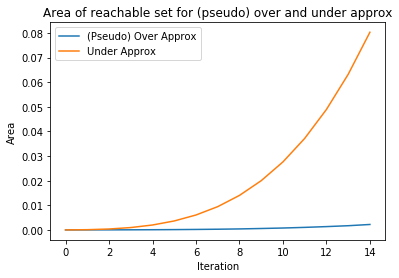

In [4]:
areas_fast = []
times_fast = []
boxes_fast = []

x0_bounds = BoxConstraints(x_lw_b,x_up_b)
y0_bounds = BoxConstraints(y_lw_b,y_up_b)
theta0_bounds = BoxConstraints(theta_lw_b,theta_up_b)
u0_bounds = BoxConstraints(control_bounds[0],control_bounds[1])

var_bounds = {"x":x0_bounds, "y":y0_bounds, "theta":theta0_bounds, "u":u0_bounds}

x_0_coeffs = {"x":1, "y":0, "theta":0, "u":0, "_const":0}
x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

y_0_coeffs = {"x":0, "y":1, "theta":0, "u":0, "_const":0}
y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)

theta_0_coeffs = {"x":0, "y":0, "theta":1, "u":0, "_const":0}
theta_0 = LinearConstraints(Line(theta_0_coeffs.copy()), Line(theta_0_coeffs.copy()),var_bounds)

u_0_coeffs = {"x":0, "y":0, "theta":0, "u":1, "_const":0}
u_0 = LinearConstraints(Line(u_0_coeffs.copy()), Line(u_0_coeffs.copy()),var_bounds)

# print("x_0")
# print(x_0.lower.coeffs)
# print(x_0.upper.coeffs)

# print("y_0")
# print(y_0.lower.coeffs)
# print(y_0.upper.coeffs)

# print("theta_0")
# print(theta_0.lower.coeffs)
# print(theta_0.upper.coeffs)

# print("u_0")
# print(u_0.lower.coeffs)
# print(u_0.upper.coeffs)

for t in range(constants["T"]):
    tt = time.time()
    V = constants["V"]
    box_x, box_y, box_theta = x_0.eval_box(), y_0.eval_box(), theta_0.eval_box()
    areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
    b = ([box_x.lower,box_x.upper],[box_y.lower,box_y.upper],[box_theta.lower,box_theta.upper])
    boxes_fast.append(b)
#     if t == 1: print(b)
    
    x_temp = theta_0.cos(adaptive=True).mult_const(constants["del_t"]*V).add(x_0)
    y_temp = theta_0.sin(adaptive=True).mult_const(constants["del_t"]*V).add(y_0)
    theta_temp = u_0.mult_const(constants["del_t"]).add(theta_0)
    x_0, y_0, theta_0 = x_temp, y_temp, theta_temp
    
    tt = time.time() - tt
    times_fast.append(tt)

fe = lambda init,constants,plot: forwardEulerDC(init,constants,plot,control_bounds=(control_bounds[0],control_bounds[1]))
print(verify_valid_boxes(boxes_fast,[x_range,y_range,theta_range],n=100000,forwardEuler=fe,constants=constants,debug=True))


$$
    0.99 \leq x_0,y_0,\theta_0 \leq 1.01
$$
$$
    -0.08414569603616028\theta + x_0 + 0.13817322513395724 \leq x_1 \leq -0.0009999833334166674\theta + x_0 + 0.1000049998750007
$$
$$
    0.05402933008747272\theta + y_0 + 0.030113561073453445 \leq y_1 \leq 0.09999500004166653\theta + y_0 + 3.333300000116224e-08
$$
$$
    -0.01 + \theta_0 \leq \theta_1 \leq 0.01 + \theta_0
$$

### CVX Reachable Set Computation

In [5]:
def DubinsConstraints(T=1,variables=[],constraints=[],control_bounds=[],Npast=0, use_convex=False, constants={}, debug=False):
    times = []
    ss = []
    boxes = []
    del_t = constants["del_t"]
    for t in range(T):
        tt = time.time()
        
        x = variables[t]["x"]
        x_bounds = bounds(x,constraints,Npast=Npast)
        y = variables[t]["y"]
        y_bounds = bounds(y,constraints,Npast=Npast)
        theta = variables[t]["theta"]
        theta_bounds = bounds(theta,constraints,Npast=Npast)
        xL,xU = x_bounds
        yL,yU = y_bounds
        thetaL,thetaU = theta_bounds
        b = ([xL,xU],[yL,yU],[thetaL,thetaU])
        boxes.append(b)
        if t == 1 and debug: print(b)
        ss.append((xU-xL)*(yU-yL))
        
        # del_t*u
        u = variables[t]["u"]
        constraints.append(u <= control_bounds[0][1]*del_t)
        constraints.append(u >= control_bounds[0][0]*del_t)
        
        # cos
        c1 = variables[t]["c1"]
        constraints.extend(cos_adaptive_cvx(c1,theta,theta_bounds,debug=(t==0 and debug)))
        
        # V*del_t*cosine
        c = variables[t]["c"]
        constraints.append(c == constants["V"]*del_t*c1)
        
        # sin
        s1 = variables[t]["s1"]
        constraints.extend(sin_adaptive_cvx(s1,theta,theta_bounds,debug=(t==0 and debug)))
        
        # V*del_t*sine
        s = variables[t]["s"]
        constraints.append(s == constants["V"]*del_t*s1)
        
        x_new = variables[t+1]["x"]
        constraints.append(x_new == c + x)
        
        y_new = variables[t+1]["y"]
        constraints.append(y_new == s + y)
        
        theta_new = variables[t+1]["theta"]
        constraints.append(theta_new == u + theta)

        tt = time.time() - tt
        times.append(tt)

    
    return variables,constraints, times, ss, boxes

$$
    -0.01 \leq u \leq 0.01
$$
$$
    0.99 \leq x_0,y_0,\theta_0 \leq 1.01
$$
$$
    -0.8414569603616077\theta + 1.3817322513395793 \leq c_1 \leq -0.8414709848078965\theta + 1.3817732906760363
$$
$$
    c = 0.1c_1
$$
$$
    0.5402933008747386\theta + 0.3011356107345292 \leq s_1 \leq 0.5403023058681398\theta + 0.30116867893975674
$$
$$
    s = 0.1s_1
$$
$$
    x_1 == c + x_0
$$
$$
    y_1 == s + y_0
$$
$$
    \theta_1 == u + \theta_0
$$

In [6]:
variables = [{"u":cvxpy.Variable(),"c1":cvxpy.Variable(),"s1":cvxpy.Variable(),"c":cvxpy.Variable(),"s":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"theta":cvxpy.Variable()} for t in range(T+1)]

# plt.figure(2)
# plt.plot([x_lw_b,x_lw_b,x_up_b,x_up_b,x_lw_b],[y_lw_b,y_up_b,y_up_b,y_lw_b,y_lw_b],'b')

x = variables[0]["x"]
y = variables[0]["y"]
theta = variables[0]["theta"]

constraints = []
constraints.append(x >= x_lw_b)
constraints.append(x <= x_up_b)
constraints.append(y >= y_lw_b)
constraints.append(y <= y_up_b)
constraints.append(theta >= theta_lw_b)
constraints.append(theta <= theta_up_b)

control_bounds_cvx = [(control_bounds[0], control_bounds[1]) for t in range(T)]

variables_convex,constraints_convex,times_convex,areas_convex,boxes_convex = DubinsConstraints(T,variables,constraints,control_bounds_cvx,use_convex=False,constants=constants,debug=True)
xL,xU = bounds(variables[-1]["x"],constraints)
yL,yU = bounds(variables[-1]["y"],constraints)
thetaL,thetaU = bounds(variables[-1]["theta"],constraints)


Academic license - for non-commercial use only
cos(x) lower:  {'_const': 1.3817322513395793, 'x_cos': -0.8414569603616077}
cos(x) upper:  {'_const': 1.3817732906760363, 'x_cos': -0.8414709848078965}
sin(x) lower:  {'_const': 0.3011356107345292, 'x_sin': 0.5402933008747386}
sin(x) upper:  {'_const': 0.30116867893975674, 'x_sin': 0.5403023058681398}
([1.0431860721374355, 1.0648717015716218], [1.073602597860052, 1.0946874007866578], [0.98, 1.02])


True


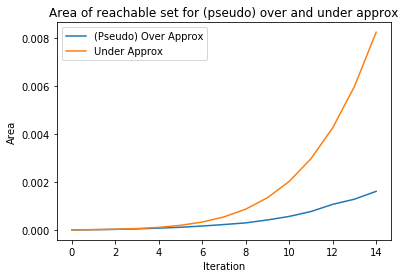

In [7]:
fe = lambda init,constants,plot: forwardEulerDC(init,constants,plot,control_bounds=(control_bounds[0],control_bounds[1]))
print(verify_valid_boxes(boxes_convex,[x_range,y_range,theta_range],n=10000,forwardEuler=fe,constants=constants,debug=True))

### Visualizations

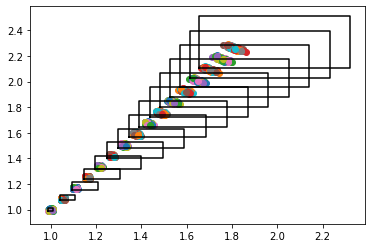

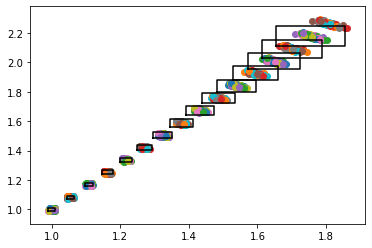

In [8]:
trajs = random_trajs([x_range,y_range,theta_range],forwardEulerDC,constants,n=100)
plot_2d_boxes_traj(boxes_fast, trajs)
plot_2d_boxes_traj(boxes_convex, trajs)

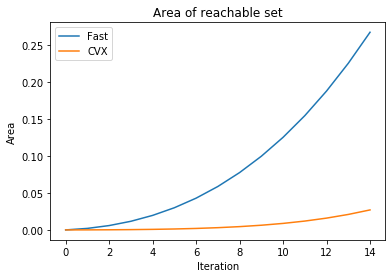

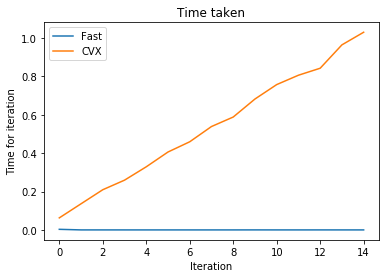

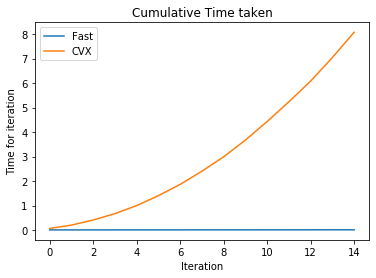

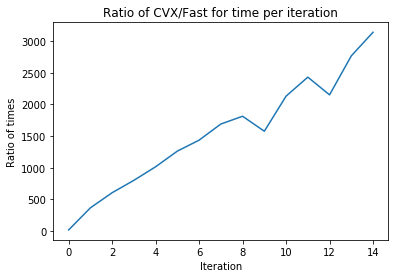

In [9]:
convex_res = {"area":areas_convex, "time":times_convex}
fast_res = {"area":areas_fast, "time":times_fast}
visualize(convex_res,fast_res)

### Verify Boxes Found are Valid via Sampling

Sample the space of initial conditions and forward propogate trajectories using the forward Euler method to validate if trajectories remain within boxed sets found via both the CVX approach or the fast approach.

NOTE: Forward euler assumes constant control at $u_t \equiv 1$. Should change in the future.

True
True


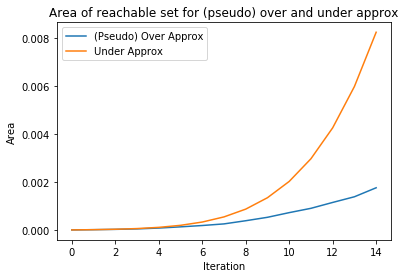

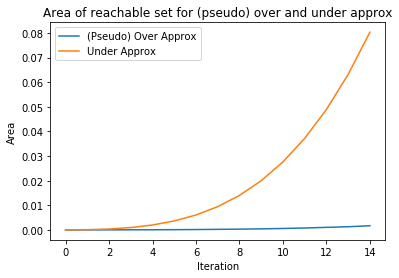

In [10]:
num_samples = 10000
print(verify_valid_boxes(boxes_convex,[x_range,y_range,theta_range],n=num_samples,forwardEuler=forwardEulerDC,constants=constants))
print(verify_valid_boxes(boxes_fast,[x_range,y_range,theta_range],n=num_samples,forwardEuler=forwardEulerDC,constants=constants))

## Bounding box using outer approximation

### Fast

(14, 7)


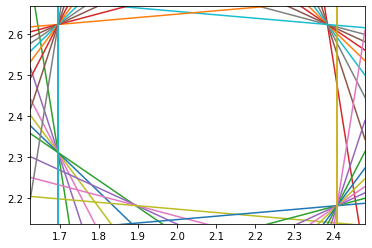

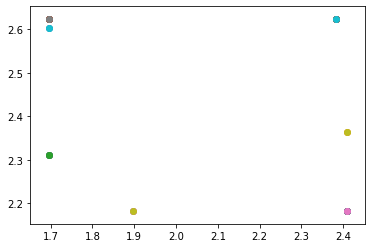

In [11]:
variables = {"x":x_0,"y":y_0,"theta":theta_0}
A, b, proj_dim = linear_to_polytope(var_bounds, variables, order=["x", "y", "theta"])
print(A.shape)
plot_outer_approximation(20,A,b,100,start_idx=4)

### CVX

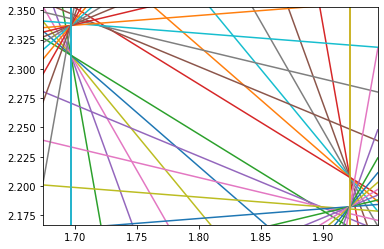

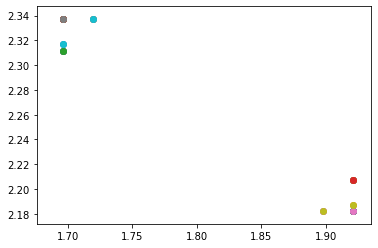

In [12]:
plot_outer_approximation_cvx(20,variables_convex,constraints_convex,100)

## Comparing Inequalities for first box

CVX:

$$
    0.99 \leq x_0,y_0,\theta_0 \leq 1.01
$$
$$
    -0.08414569603616077\theta + x_0 + 0.13817322513395793 \leq x_1 \leq -0.08414709848078965\theta + x_0 + 0.13817732906760363
$$
$$
    0.05402933008747386\theta + y_0 + 0.03011356107345292 \leq y_1 \leq 0.05403023058681398\theta + y_0 + 0.030116867893975674
$$
$$
    -0.01 + \theta_0 \leq \theta_1 \leq 0.01 + \theta_0
$$

Box: ([1.0431860721374355, 1.0648717015716218], [1.073602597860052, 1.0946874007866578], [0.98, 1.02])

Linear:

$$
    0.99 \leq x_0,y_0,\theta_0 \leq 1.01
$$
$$
    -0.08414569603616028\theta + x_0 + 0.13817322513395724 \leq x_1 \leq -0.0009999833334166674\theta + x_0 + 0.1000049998750007
$$
$$
    0.05402933008747272\theta + y_0 + 0.030113561073453445 \leq y_1 \leq 0.09999500004166653\theta + y_0 + 3.333300000116224e-08
$$
$$
    -0.01 + \theta_0 \leq \theta_1 \leq 0.01 + \theta_0
$$

Box: ([1.0431860721374355, 1.1090150163749184], [1.0736025978600514, 1.1109949833750832], [0.98, 1.02])

## Experiment with Different Controls

In [13]:
control_bounds_list = [(-0.01,0.01), (-0.1,0.1), (-1.0,1.0), 
                       (-np.pi + 0.00001,np.pi), (0,np.pi)]
control_bounds_list = [(-r,r) for r in np.linspace(0,np.pi,20)]


Change to use different u for each iteration!

In [14]:
res_fast = {}
for control_bounds in control_bounds_list:
    areas_fast = []
    times_fast = []
    boxes_fast = []

    x0_bounds = BoxConstraints(x_lw_b,x_up_b)
    y0_bounds = BoxConstraints(y_lw_b,y_up_b)
    theta0_bounds = BoxConstraints(theta_lw_b,theta_up_b)
    u0_bounds = BoxConstraints(control_bounds[0],control_bounds[1])

    var_bounds = {"x":x0_bounds, "y":y0_bounds, "theta":theta0_bounds}
    for t in range(constants["T"]): var_bounds["u"+str(t)] = u0_bounds

    x_0_coeffs = {"x":1, "y":0, "theta":0, "_const":0}
    for t in range(constants["T"]): x_0_coeffs["u"+str(t)] = 0
    x_0 = LinearConstraints(Line(x_0_coeffs.copy()), Line(x_0_coeffs.copy()),var_bounds)

    y_0_coeffs = {"x":0, "y":1, "theta":0, "_const":0}
    for t in range(constants["T"]): y_0_coeffs["u"+str(t)] = 0
    y_0 = LinearConstraints(Line(y_0_coeffs.copy()), Line(y_0_coeffs.copy()),var_bounds)
    
    theta_0_coeffs = {"x":0, "y":0, "theta":1, "_const":0}
    for t in range(constants["T"]): theta_0_coeffs["u"+str(t)] = 0
    theta_0 = LinearConstraints(Line(theta_0_coeffs.copy()), Line(theta_0_coeffs.copy()),var_bounds)

    for t in range(constants["T"]):
        u_0_coeffs = {"x":0, "y":0, "theta":0, "_const":0}
        for k in range(constants["T"]): u_0_coeffs["u"+str(k)] = 0
        u_0_coeffs["u"+str(t)] = 1
        u_0 = LinearConstraints(Line(u_0_coeffs.copy()), Line(u_0_coeffs.copy()),var_bounds)
        
        tt = time.time()
        V = constants["V"]
        box_x, box_y, box_theta = x_0.eval_box(), y_0.eval_box(), theta_0.eval_box()
        areas_fast.append((box_x.upper-box_x.lower)*(box_y.upper-box_y.lower))
        b = ([box_x.lower,box_x.upper],[box_y.lower,box_y.upper],[box_theta.lower,box_theta.upper])
        boxes_fast.append(b)

        x_temp = theta_0.cos(adaptive=True).mult_const(constants["del_t"]*V).add(x_0)
        y_temp = theta_0.sin(adaptive=True).mult_const(constants["del_t"]*V).add(y_0)
        theta_temp = u_0.mult_const(constants["del_t"]).add(theta_0)
        x_0, y_0, theta_0 = x_temp, y_temp, theta_temp

        tt = time.time() - tt
        times_fast.append(tt)
    
    res_fast[control_bounds] = {"areas":areas_fast, "times":times_fast, "boxes":boxes_fast}
    

In [15]:
res_convex = {}
for control_bounds in control_bounds_list:
    variables = [{"u":cvxpy.Variable(),"c1":cvxpy.Variable(),"s1":cvxpy.Variable(),"c":cvxpy.Variable(),"s":cvxpy.Variable(),"x":cvxpy.Variable(),"y":cvxpy.Variable(),"theta":cvxpy.Variable()} for t in range(T+1)]

    x = variables[0]["x"]
    y = variables[0]["y"]
    theta = variables[0]["theta"]

    constraints = []
    constraints.append(x >= x_lw_b)
    constraints.append(x <= x_up_b)
    constraints.append(y >= y_lw_b)
    constraints.append(y <= y_up_b)
    constraints.append(theta >= theta_lw_b)
    constraints.append(theta <= theta_up_b)

    u_bounds = [control_bounds[:] for t in range(T)]

    variables,constraints,times_convex,areas_convex,boxes_convex = DubinsConstraints(T,variables,constraints,u_bounds,use_convex=False,constants=constants,debug=False)
    xL,xU = bounds(variables[-1]["x"],constraints)
    yL,yU = bounds(variables[-1]["y"],constraints)
    thetaL,thetaU = bounds(variables[-1]["theta"],constraints)
    
    res_convex[control_bounds] = {"areas":areas_convex, "times":times_convex, "boxes":boxes_convex}

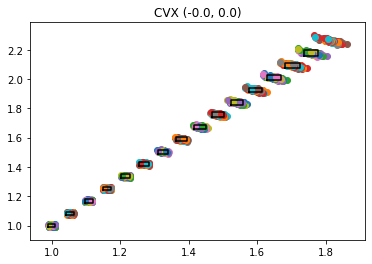

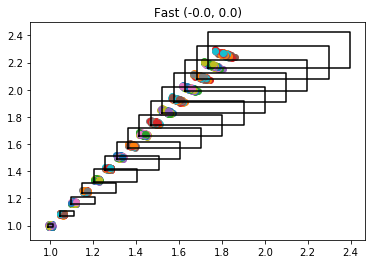

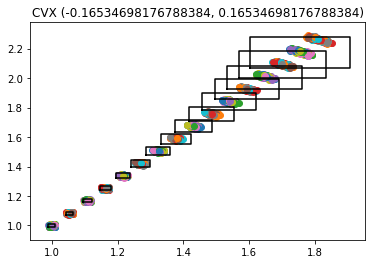

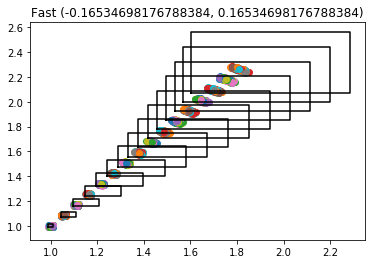

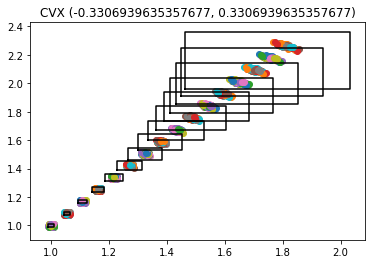

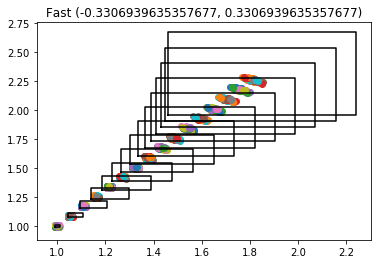

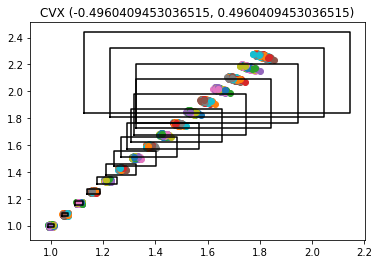

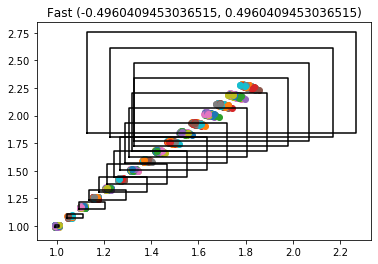

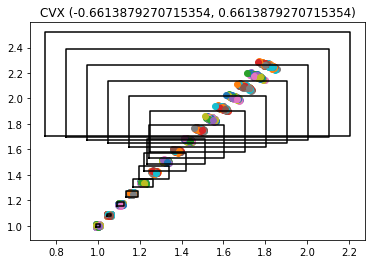

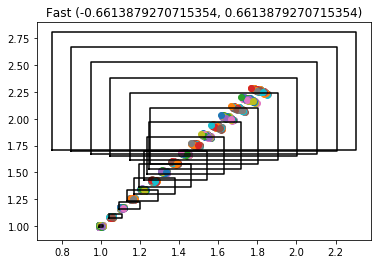

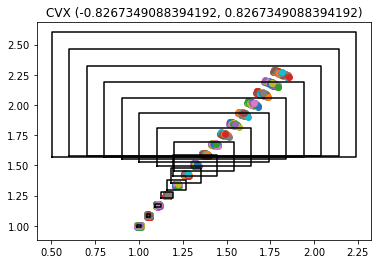

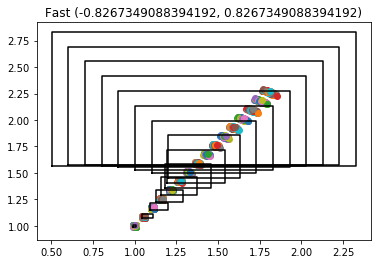

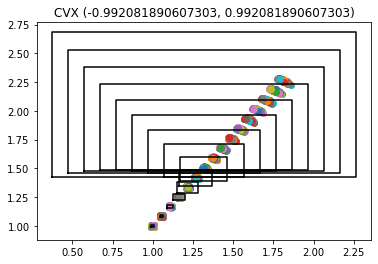

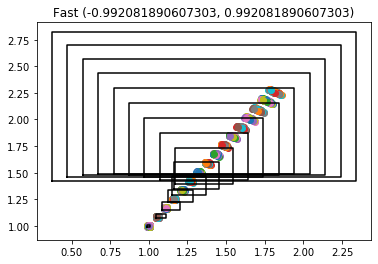

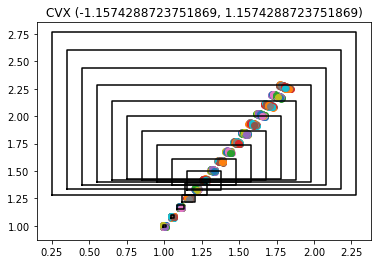

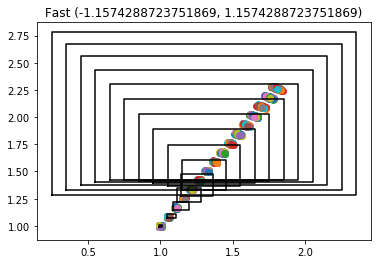

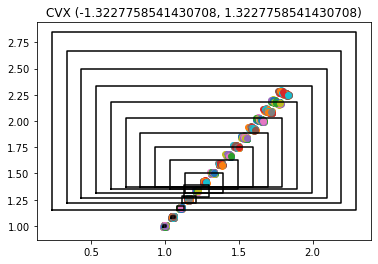

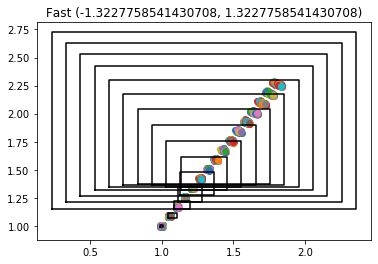

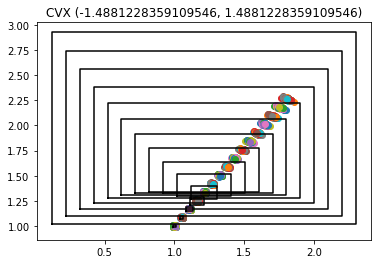

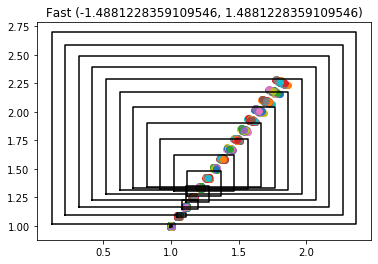

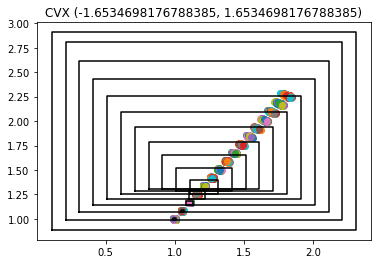

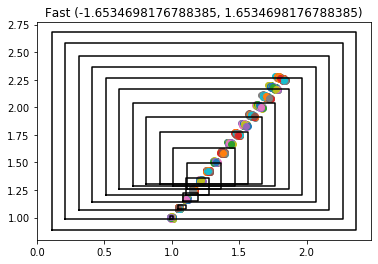

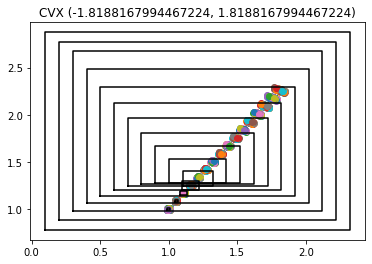

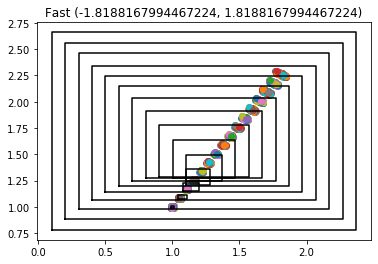

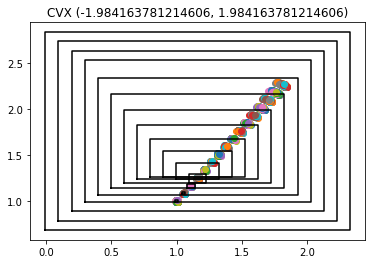

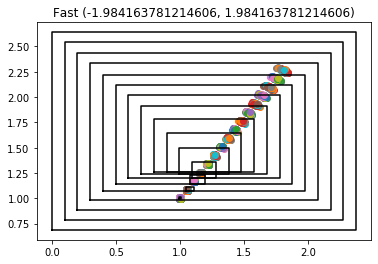

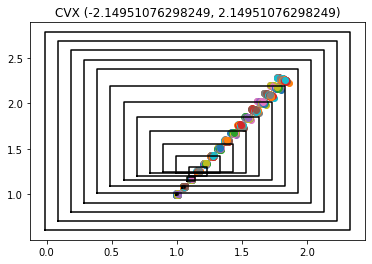

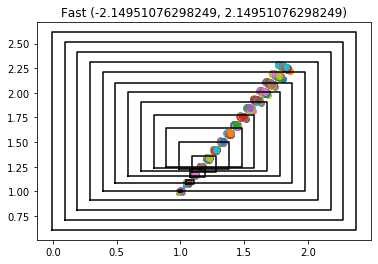

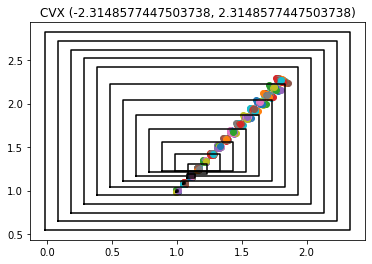

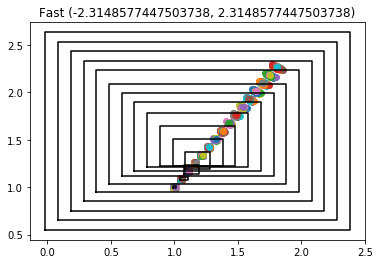

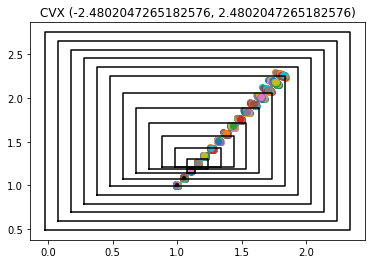

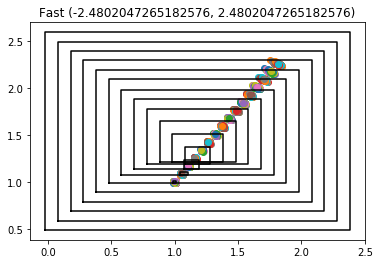

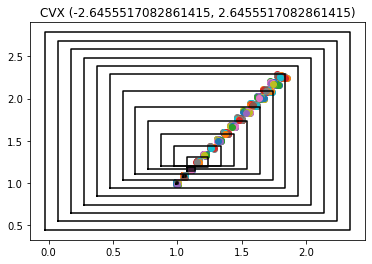

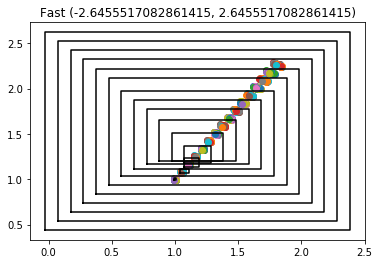

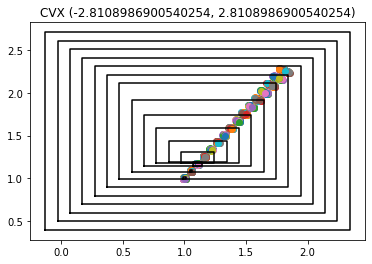

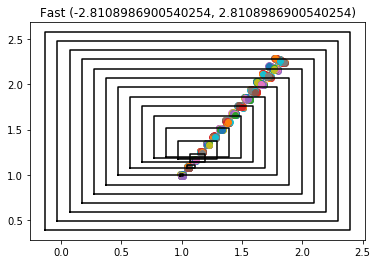

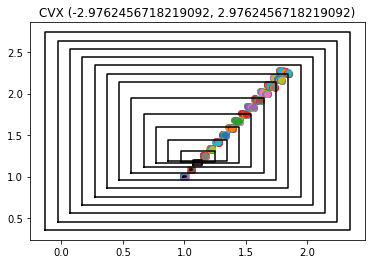

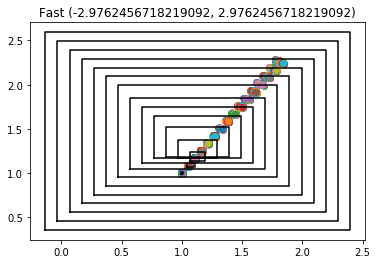

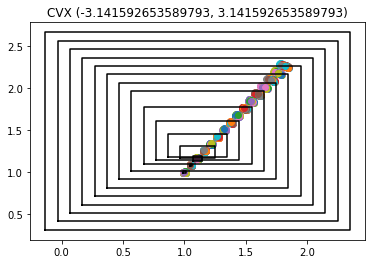

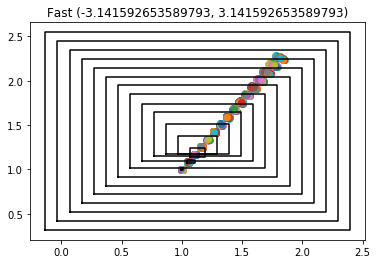

In [24]:
for control_bounds in control_bounds_list:
    r_cvx = res_convex[control_bounds]
    r_fast = res_fast[control_bounds]
    
    trajs = random_trajs([x_range,y_range,theta_range],forwardEulerDC,constants,n=100)
    plot_2d_boxes_traj(r_cvx["boxes"], trajs, name="CVX " + str(control_bounds))
    plot_2d_boxes_traj(r_fast["boxes"], trajs, name="Fast " + str(control_bounds))

In [17]:
control_bounds_list.sort(key=lambda x:x[1]-x[0])

### Area of FRS vs Size of Control Set

In [18]:
def plot_area_v_u(n,res_convex, res_fast, control_bounds_list):
    cvx_res = []
    fast_res = []
    for control_bounds in control_bounds_list:
        r_cvx = res_convex[control_bounds]
        r_fast = res_fast[control_bounds]
        cvx_res.append(r_cvx["areas"][n])
        fast_res.append(r_fast["areas"][n])
    control_sizes = [c[1]-c[0] for c in control_bounds_list]
    plt.figure()
    plt.title("Area vs control set size for n = " + str(n))
    plt.plot(control_sizes, cvx_res, label="cvx")
    plt.plot(control_sizes, fast_res, label="fast")
    plt.xlabel("Control set size")
    plt.ylabel("(Approx.) Size of reachable set " + str(n))
    plt.legend()

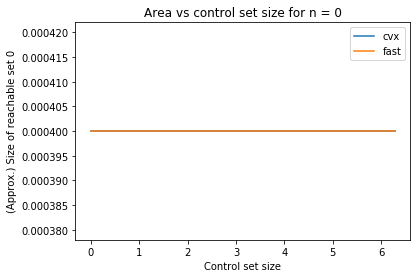

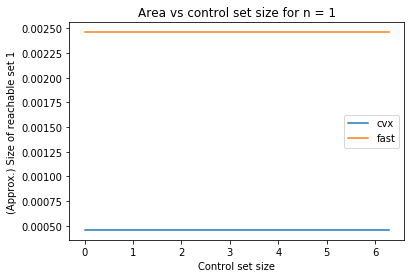

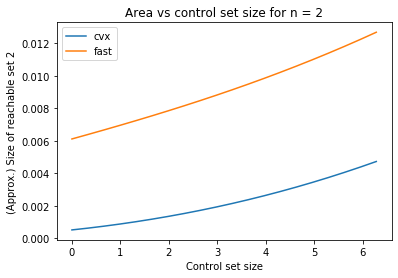

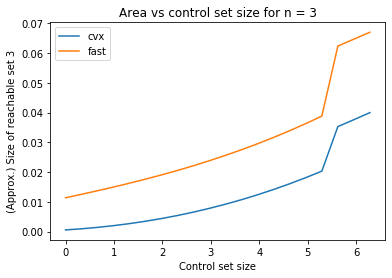

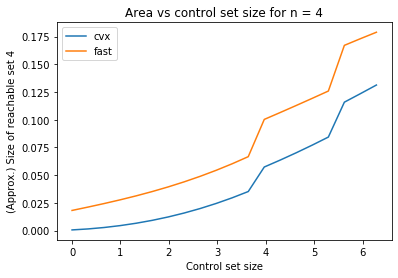

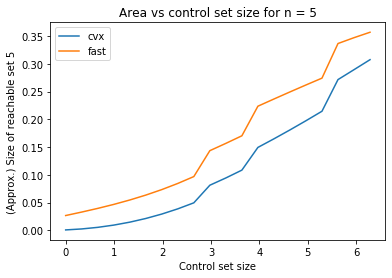

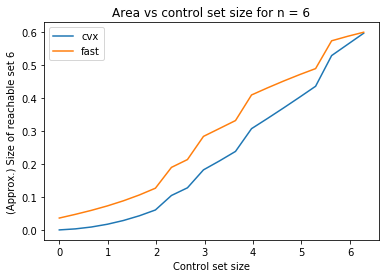

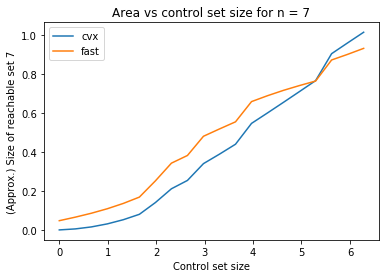

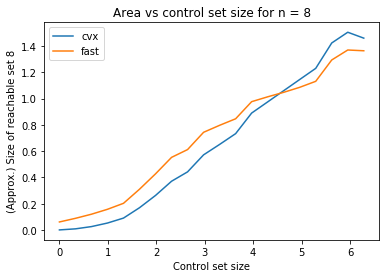

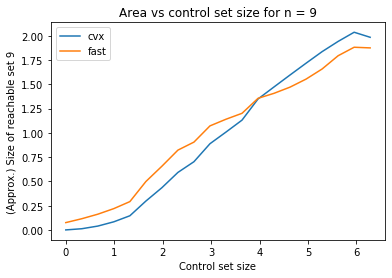

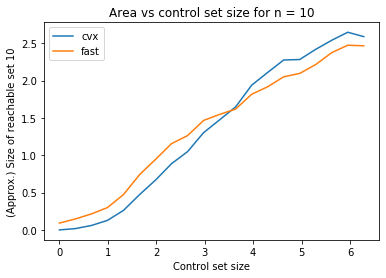

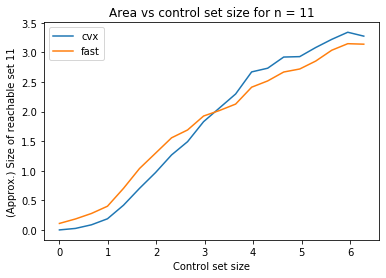

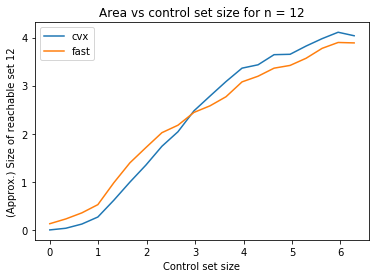

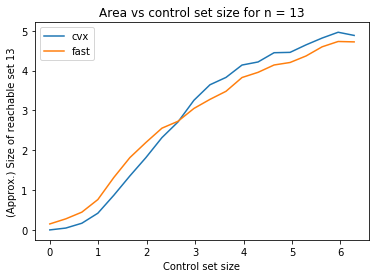

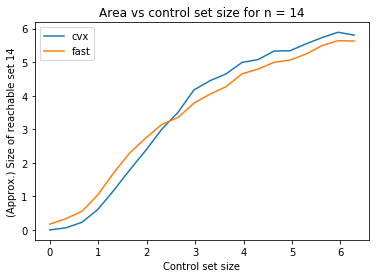

In [19]:
for i in range(15): plot_area_v_u(i,res_convex, res_fast, control_bounds_list)